In [13]:
import ipynb.fs.full.preProcessing as preProcess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import re
import json
import seaborn as sns
import random

random.seed(1301266)

DECISION TREE MODEL:

Models: DecisionTreeRegressor, AdaBoostRegressor, RandomForestRegressor
```
DEPTH = 5
models = {
    "regressor": DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=400, random_state=1301266),
    "rf": RandomForestRegressor(n_estimators=100, max_depth=DEPTH)
}
```

Output: Offence rate at time t (t in 2015, 2016 due to limited communities data)
Assumptions: The communities.csv contains the data for 2014, 2015 (assume constant across the span of 2-3 years)
Features input: 
1. All features from communities (with 2 extra features for distance) at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
2. Only the top 20 features from communities with the highest NMI with offence rate at t-1, housing price at t-1, egm at t-1, offence rate at t-1 
3. Use 1. with PCA on all communities feature (add the getPCA function)
4. Use 2. with PCA on all communities feature (add the getPCA function)

Evaluation: 50 folds validation, and take the median of RMSE/ MSE

Results: Noted below

Conclusion:
For both features set, only adaboost performs better than re-use the offence rate at (t-1).
Features set 2 results in a lower RMSE for adaboost and random forest.


In [14]:
# Preparing the frame for training model
offences = preProcess.cleanedOffences
offences = offences.drop(columns=["Offence Count"])

communities = preProcess.cleanedCommunities
communities["Distance from Melbourne"] = np.sqrt(communities["Location_x"]**2 + communities["Location_y"]**2)
communities["Direction from Melbourne"] = np.arctan(communities["Location_x"]/ communities["Location_y"])

housingPrices = preProcess.cleanedHousingPrice
egm = preProcess.cleanedEgm


In [15]:
from sklearn.preprocessing import OneHotEncoder

modelData = offences[(offences["Year"] == 2015) | (offences["Year"] == 2016)]
modelData = pd.merge(left=modelData, right=communities, how="left", on="LGA")

for idx, row in modelData.iterrows():
    modelData.loc[idx, "Last Offence Rate"] = offences[(offences["LGA"] == row["LGA"]) 
                                            & (offences["Year"] == row["Year"] - 1)]["Rate per 100,000 population"].iloc[0]
    modelData.loc[idx, "Last Housing Price"] = housingPrices.loc[row["LGA"]][str(row["Year"] - 1)]
    modelData.loc[idx, "Last EGM"] = egm.loc[row["LGA"]][str(row["Year"] - 1)]


In [16]:
from sklearn.model_selection import train_test_split

# One hot the LGA - Use inverse transform from the encoder to get back the lga

oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["LGA"]).reshape(-1, 1))
oneHotLGA = pd.DataFrame(oneHotEncoder
                         .transform(np.array(modelData["LGA"]).reshape(-1, 1))
                         .toarray())
renameCol = {}
for column in oneHotLGA.columns:
    renameCol[column] = "LGA" + str(column)
oneHotLGA = oneHotLGA.rename(columns=renameCol)
modelData = modelData.join(oneHotLGA)
modelData = modelData.drop(columns=["LGA"])

# One hot the region
# oneHotEncoder = OneHotEncoder(handle_unknown='ignore').fit(np.array(modelData["Police Region"]).reshape(-1, 1))
# oneHotRegion = pd.DataFrame(oneHotEncoder
#                          .transform(np.array(modelData["Police Region"]).reshape(-1, 1))
#                          .toarray())
# renameCol = {}
# for column in oneHotRegion.columns:
#     renameCol[column] = "Region" + str(column)
# oneHotRegion = oneHotRegion.rename(columns=renameCol)
# modelData = modelData.join(oneHotRegion)
# modelData = modelData.drop(columns=["Police Region"])

raw_raw_X = modelData.drop(columns=["Rate per 100,000 population", "Year"])
raw_raw_y = modelData["Rate per 100,000 population"] 
raw_X, X_test, raw_y, y_test = train_test_split(raw_raw_X, raw_raw_y, test_size=0.1, random_state=100)

X = raw_X
y = raw_y

print(X_test.index)
print(y_test.index)

modelData

Index([25, 51, 21, 26, 64, 43, 29, 92, 75, 85, 41, 78], dtype='int64')
Index([25, 51, 21, 26, 64, 43, 29, 92, 75, 85, 41, 78], dtype='int64')


,Year,"Rate per 100,000 population",Travel time to GPO (minutes),Area (km^2),ARIA+ (min),ARIA+ (max),ARIA+ (avg),Commercial (km^2),Industrial (km^2),Residential (km^2),...,LGA46,LGA47,LGA48,LGA49,LGA50,LGA51,LGA52,LGA53,LGA54,LGA55
0,2015,3705.064854,262.158611,12672.409204,2.009198,3.766950,2.820244,0.000036,0.000190,0.002115,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015,11142.200000,79.549092,654.711013,0.223566,0.371822,0.298394,0.003524,0.018142,0.101532,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015,7317.100000,20.289781,84.535123,0.000000,0.000000,0.000000,0.008991,0.021552,0.605656,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2015,8552.300000,106.172618,680.448934,1.334959,1.444840,1.384334,0.001338,0.001232,0.068730,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015,7883.000000,92.193741,4830.163654,0.723223,1.483585,1.084508,0.000219,0.000686,0.011533,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,2016,7314.794207,35.366070,937.879053,0.006308,0.058839,0.025918,0.003475,0.007859,0.129223,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
108,2016,8254.400000,215.072447,989.067744,0.673554,0.989005,0.794905,0.001546,0.011770,0.041257,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
109,2016,6775.100000,26.826134,517.402245,0.002064,0.009205,0.005557,0.003649,0.054778,0.159123,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
110,2016,15075.200000,6.485248,20.822930,0.000000,0.000000,0.000000,0.127473,0.038506,0.484912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [17]:
from sklearn.decomposition import PCA
def getPCA(X_train, X_test, y_train = None):
    sklearn_pca = PCA(n_components=1)
    features_pca = sklearn_pca.fit(X_train)
    X_train["pca"] = features_pca.transform(X_train)
    X_test["pca"] = features_pca.transform(X_test)
    return X_train, X_test

In [18]:
def getSplitAttributes(tree_rules: str):
    # Parsing the split attributes
    splitAtts = []
    AttRegex = r".*\|--- ([^<>=]*) [<>=].*"

    for line in tree_rules.split("\n"):
        # print(line)
        matchObj = re.match(AttRegex, line)
        if matchObj:
            att = matchObj.group(1)
            splitAtts.append(att)
            # print(att)
    return splitAtts

In [19]:
class NullModel():
    def __init__(self) -> None:
        self.trainMean = 0

    def fit(self, X_train, y_train):
        self.trainMean = np.mean(y_train)
        return self
    
    def predict(self, X_test):
        return [self.trainMean] * len(X_test)


In [20]:
from sklearn.metrics import mean_squared_error

def trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models, printable = True):
    if featureEngineerFunc:
        X_train, X_test = featureEngineerFunc(X_train, X_test, y_train)    
    predicts = {}
    mses = {}

    for name in models:
        model = models[name]
        models[name] = model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        predicts[name] = y_predict

    # Get the default mse using last rate
    modelTest = modelData.loc[X_test.index]
    mse_null_2 = mean_squared_error(modelTest["Rate per 100,000 population"], modelTest["Last Offence Rate"])
    mses["null2"] = mse_null_2


    for name in models:
        mses[name] = (mean_squared_error(predicts[name], y_test))
        
    if printable:
        for key in mses:
            print("RMSE of ", key, ":", np.sqrt(mses[key]))
    return X_train, X_test, mses, predicts

In [21]:
# K-fold, since the above is pretty random
from sklearn.model_selection import KFold
from sklearn.tree import plot_tree, export_text

def KFoldPipeline(X, y,
                  featureEngineerFunc, models, 
                  n = 10, printable = True, 
                  X_val = None, y_val = None):
    # Change to 50 for actual evaluation

    nf_CV = KFold(n_splits=n, shuffle=True, random_state=42)
    msesTotal = {}

    # relavantAttributes = []
    relavantAttributes = {}


    for train_idx, test_idx in nf_CV.split(X):
        # train-test split
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        if X_val is not None:
            X_train = pd.concat([X_train, X_val])
            y_train = pd.concat([y_train, y_val])

        X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test,
                                           featureEngineerFunc, models, 
                                           printable=False)

        for key in mses:
            if key not in msesTotal:
                msesTotal[key] = []
            msesTotal[key].append(mses[key])

        # Get the summary of all attributes
        # if "regressor" in models:
        #     tree_rules = export_text(models["regressor"], feature_names=list(X_train))
        #     relavantAttributes.extend(getSplitAttributes(tree_rules))

    if printable:
        # Print the RMSE for each model
        for key in mses:
            print("MSE of", key, ":", np.median(msesTotal[key]))
            print("RMSE of", key, ":", np.median(np.sqrt(msesTotal[key])))



        print("Used attributes for regressor tree: ")
        # print(pd.Series(relavantAttributes).value_counts())

        for name in mses:
            plt.figure()
            fig, axs = plt.subplots(1, 2)
            fig.suptitle("RMSE of " + name)
            axs[0].hist(np.sqrt(msesTotal[name]))
            axs[1].boxplot(np.sqrt(msesTotal[name]))
            plt.show()
        

FEATURES 3 (and 1): All features + PCA

Remove PCA to get the feature 1 set

In [22]:
# Define models here
# Models: https://www.analyticsvidhya.com/blog/2021/09/adaboost-algorithm-a-complete-guide-for-beginners/
# AdaBoost model (TODO: Recheck source): Train an initial tree with uniform weight for all points.
# Then, for subsequent iterations, change the weights so more weights are given for
# the points with errors.
# Then, random selection based on the normalized probability weights for the data points
# to construct a new datasets => Train a new tree on top of it 
# At the end, with 300 iterations, around 300 decision trees are built and used for regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

RMSE of  null2 : 840.6042623633698
RMSE of  regressor : 1102.3413153952342
RMSE of  ada : 1018.3339240458581
RMSE of  null : 2719.842874333697


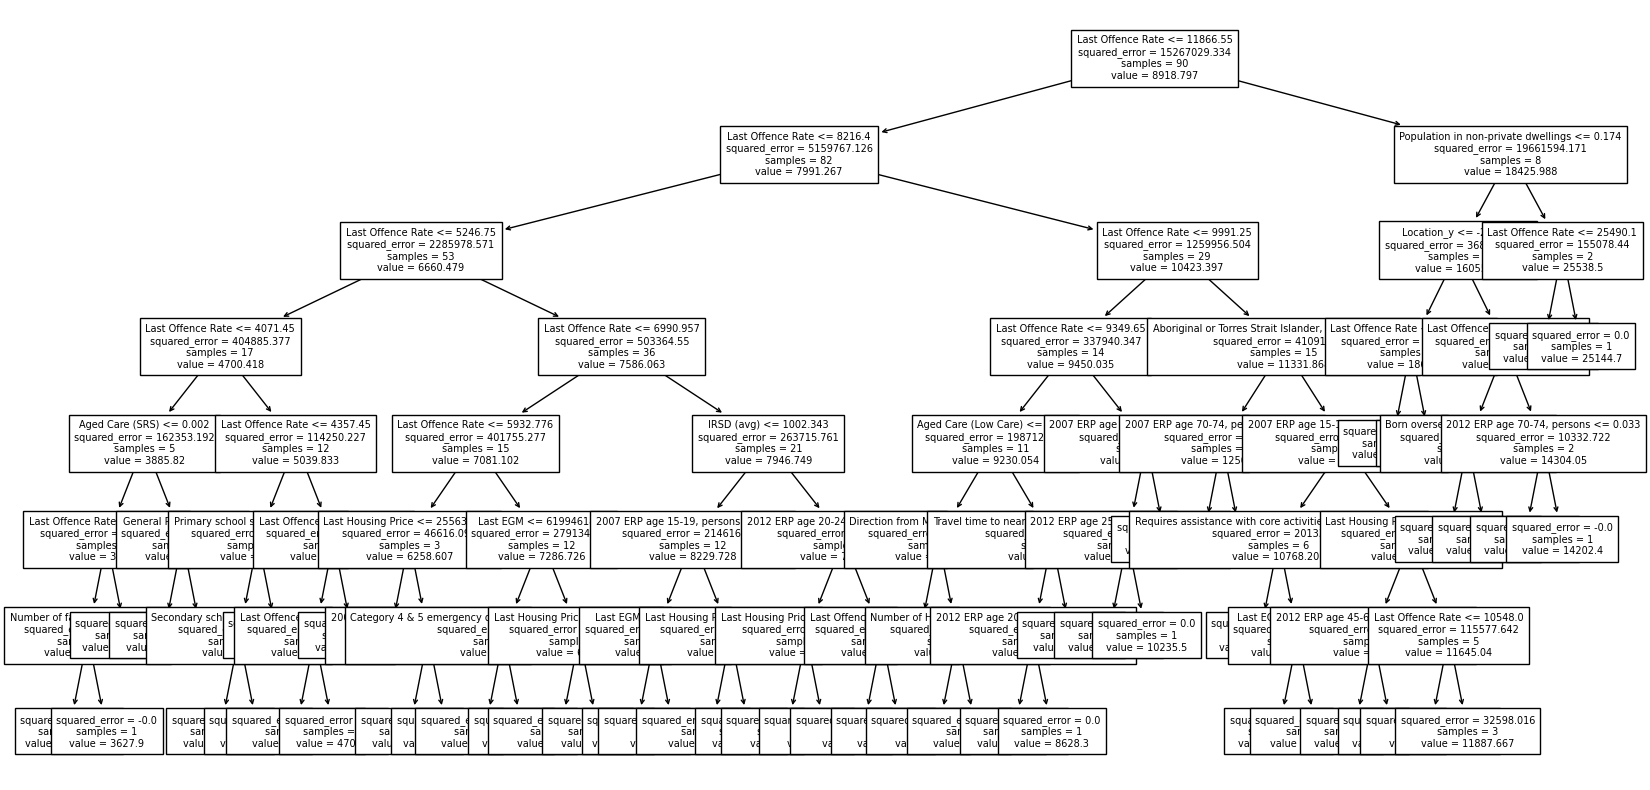

|--- Last Offence Rate <= 11866.55
|   |--- Last Offence Rate <= 8216.40
|   |   |--- Last Offence Rate <= 5246.75
|   |   |   |--- Last Offence Rate <= 4071.45
|   |   |   |   |--- Aged Care (SRS) <= 0.00
|   |   |   |   |   |--- Last Offence Rate <= 3660.34
|   |   |   |   |   |   |--- Number of families <= 20121.50
|   |   |   |   |   |   |   |--- value: [3705.06]
|   |   |   |   |   |   |--- Number of families >  20121.50
|   |   |   |   |   |   |   |--- value: [3627.90]
|   |   |   |   |   |--- Last Offence Rate >  3660.34
|   |   |   |   |   |   |--- value: [3382.74]
|   |   |   |   |--- Aged Care (SRS) >  0.00
|   |   |   |   |   |--- General Practice <= 0.00
|   |   |   |   |   |   |--- value: [4267.20]
|   |   |   |   |   |--- General Practice >  0.00
|   |   |   |   |   |   |--- value: [4446.20]
|   |   |   |--- Last Offence Rate >  4071.45
|   |   |   |   |--- Last Offence Rate <= 4357.45
|   |   |   |   |   |--- Primary school students <= 0.08
|   |   |   |   |   |   |--- S

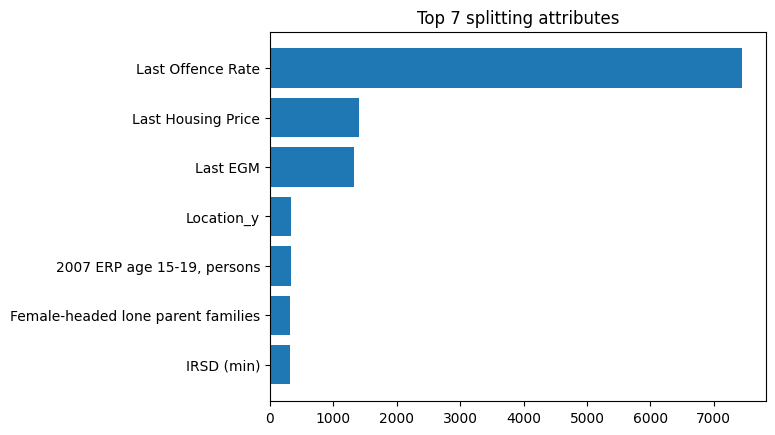

Concise list of attributes
Last Offence Rate                                8
Last EGM                                         4
Aboriginal or Torres Strait Islander, persons    2
2007 ERP age 45-64, persons                      2
2007 ERP, total                                  2
Born overseas, persons                           2
Dental                                           2
Aged Care (High Care)                            2
Population in non-private dwellings              2
ARIA+ (avg)                                      2
Allied Health                                    2
2012 ERP age 25-44, persons                      2
2012 ERP age 0-4, persons                        2
Last Housing Price                               2
Volunteers, persons                              2
ARIA+ (min)                                      2
Name: count, dtype: int64


In [23]:
# Use hold out for now, to investigate the tree closely
from sklearn.tree import plot_tree, export_text
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

# Tuning:
# To reduce validation-time, the models with 1-2 parameters are manually tune using validation set
# Regressor: 3 - 7, by 1 => Best at 5
# AdaBoost: Use regressor best depth + 100 - 400, by 100, for estimators: Best at 300
# RF: Use regressor best depth + 100-400, by 100 for n_estimators: Best at 200
# gradBoost: 
# Use regressor best depth + with GridSearchCV to fine-tune the list of possible hyper-parameters
# Use squared error since it's regression. Log-loss is for logistic regression (probability output for classification)
# Exponential is adaboost (by documentation)

# Don't have enough space, so only discuss Adaboost and Decision Tree
DEPTH = 5

models = {
    "regressor": GridSearchCV(DecisionTreeRegressor(max_depth=DEPTH, random_state=1301267),
        param_grid= {
            "max_depth": [3, 5, 7]
        }
    ),
    "ada": GridSearchCV(AdaBoostRegressor(
        GridSearchCV(DecisionTreeRegressor(max_depth=DEPTH),
            param_grid={
                "max_depth": [3, 5, 7]
            }), 
        random_state=1301266), 
        param_grid= {
            "n_estimators": [200, 300, 400]
        }
    ),
    # "rf": RandomForestRegressor(n_estimators=200, max_depth=DEPTH),
    # "gradBoost": GridSearchCV(GradientBoostingRegressor(
    #     max_depth = DEPTH,
    #     loss = "squared_error"), 
    #     param_grid={
    #         'n_estimators': [200, 300, 400],
    #         'min_samples_split': [3, 6],
    #         'learning_rate': [0.01, 0.1]
    #     }),
    # "linear": LinearRegression(),
    "null": NullModel()
}

#  Initial check to make sure it works
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=100)
X_train, X_test, mses, predicts = trainTestPipeline(X_train, X_test, y_train, y_test, None, models)

# Check the decision tree regressor
fig, axe = plt.subplots(figsize=(20,10))
plot_tree(models["regressor"].best_estimator_, 
          feature_names=X_train.columns,
          ax=axe, 
          fontsize=7)
plt.show()

# Use text
tree_rules = export_text(models["regressor"].best_estimator_, feature_names=list(X_train))
print(tree_rules)

relevantAttributes = {}

model = models["ada"].best_estimator_
for i in range(len(model.estimators_)):
    estimator = model.estimators_[i].best_estimator_
    weight = model.estimator_weights_[i]
    tree_rules = export_text(estimator, feature_names=list(X_train.columns))
    for att in getSplitAttributes(tree_rules):
        if att not in relevantAttributes:
            relevantAttributes[att] = 0
        relevantAttributes[att] += weight

descPairs = list(relevantAttributes.items())
descPairs.sort(key = lambda x: -x[1])

plt.figure()
plt.title("Top 7 splitting attributes")
plt.barh([pair[0] for pair in descPairs[:7][::-1]], [pair[1] for pair in descPairs[:7][::-1]])
plt.show()


print("Concise list of attributes")
print(pd.Series(getSplitAttributes(tree_rules)).value_counts())


In [24]:
# FEATURE 1:
featureEngineerFunc = None
# featureEngineerFunc = getPCA
KFoldPipeline(X, y, featureEngineerFunc, models, 10, True)

KeyboardInterrupt: 

C:\Users\DELL\AppData\Local\Temp\ipykernel_20912\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20912\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
C:\Users\DELL\AppData\Local\Temp\ipykernel_20912\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

MSE of null2 : 533531.4335127556
RMSE of null2 : 730.1508993352018
MSE of regressor : 666556.662949132
RMSE of regressor : 816.4102033528111
MSE of ada : 444860.56797001255
RMSE of ada : 666.4849108719856
MSE of rf : 1030627.7786487102
RMSE of rf : 999.0629606925914
MSE of gradBoost : 605356.4186169449
RMSE of gradBoost : 777.3641745041875
MSE of linear : 669284.1080752164
RMSE of linear : 817.236649711245
MSE of null : 9968752.571479458
RMSE of null : 3157.2728578490787
Used attributes for regressor tree: 


<Figure size 640x480 with 0 Axes>

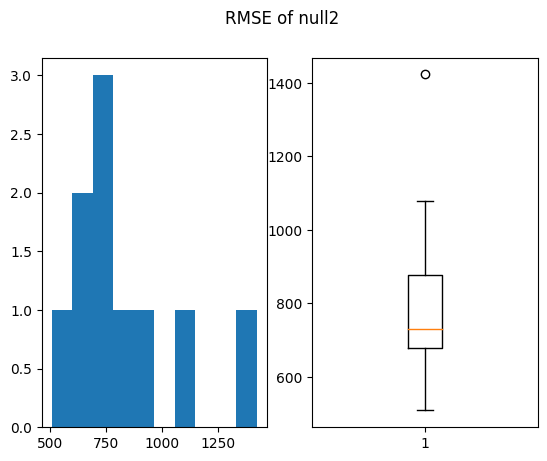

<Figure size 640x480 with 0 Axes>

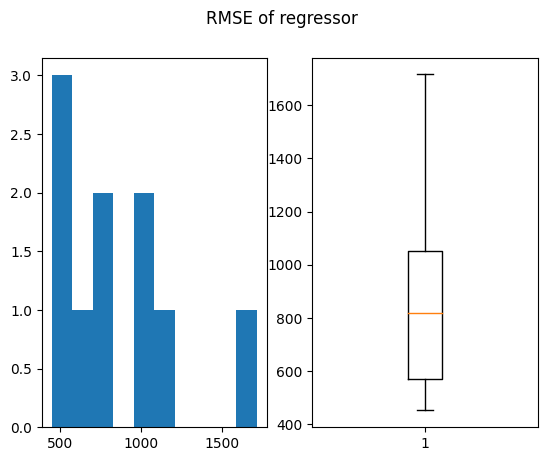

<Figure size 640x480 with 0 Axes>

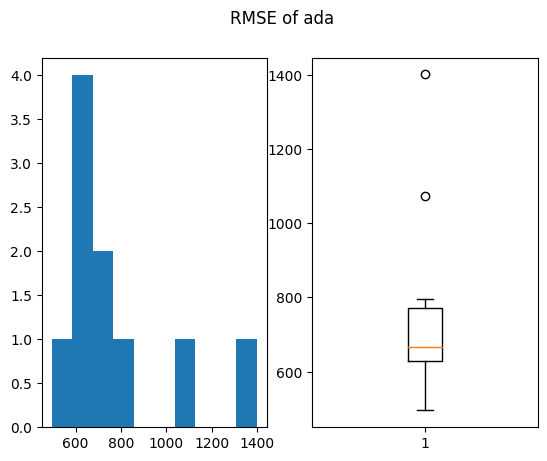

<Figure size 640x480 with 0 Axes>

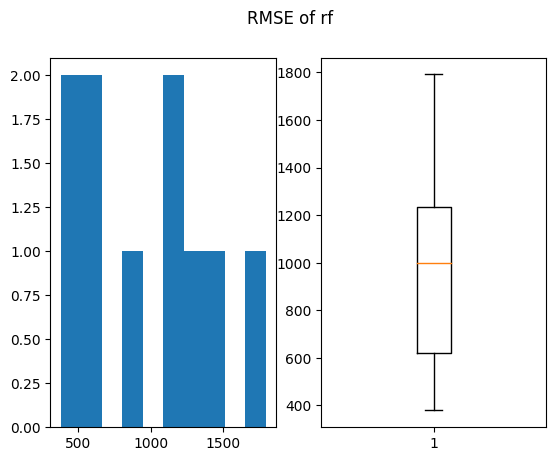

<Figure size 640x480 with 0 Axes>

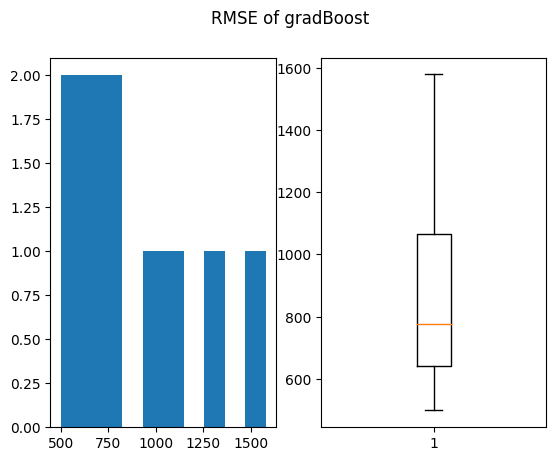

<Figure size 640x480 with 0 Axes>

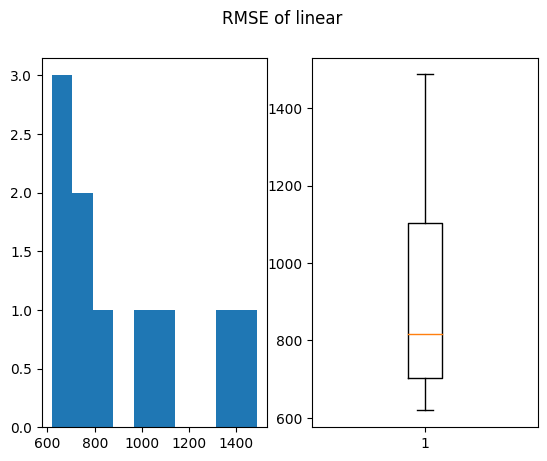

<Figure size 640x480 with 0 Axes>

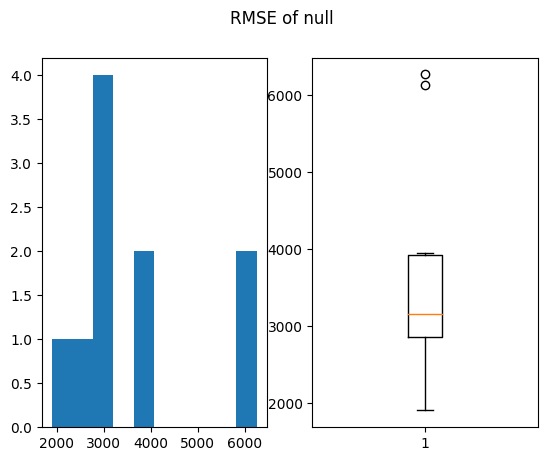

In [54]:
# FEATURE 3:
featureEngineerFunc = getPCA
KFoldPipeline(X, y, featureEngineerFunc, models, 10, True)

FEATURE 4 (and 2): Pick the top 20 highest NMI score features only + PCA

Remove the getPCA to achieve the feature 2 (no PCA).

In [55]:
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

# Since most attribute uses the default discretiser, 
# this function will help with the NMI calculation
def getNMI(att1: np.array, att2: np.array, n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="quantile")
    # Avoid the removal of bin by normalizing the data
    norm_att1 = (att1 - att1.min())/ (att1.max() - att1.min()) * 100
    norm_att2 = (att2 - att2.min())/ (att2.max() - att2.min()) * 100

    discrete_att1 = discretizer.fit_transform(norm_att1.reshape(-1, 1)).astype(int)
    discrete_att2 = discretizer.fit_transform(norm_att2.reshape(-1, 1)).astype(int)
    return normalized_mutual_info_score(discrete_att1.flatten(), discrete_att2.flatten())

def getTopNMICommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = getNMI(np.array(X_train[column]), np.array(y_train))
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerFunc2(X_train, X_test, y_train):
    top20Communities = getTopNMICommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

def featureEngineerFunc4(X_train, X_test, y_train):
    X_train, X_test = getPCA(X_train, X_test)
    return featureEngineerFunc2(X_train, X_test, y_train)

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

MSE of null2 : 533531.4335127556
RMSE of null2 : 730.1508993352018
MSE of regressor : 625891.5112003733
RMSE of regressor : 791.1194466774497
MSE of ada : 386773.60360693815
RMSE of ada : 621.8048852218637
MSE of rf : 854453.3521065391
RMSE of rf : 888.7574950350568
MSE of gradBoost : 589566.2337147145
RMSE of gradBoost : 767.5855790280834
MSE of linear : 209807477.84123355
RMSE of linear : 14484.65790003366
MSE of null : 9968752.571479458
RMSE of null : 3157.2728578490787
Used attributes for regressor tree: 


<Figure size 640x480 with 0 Axes>

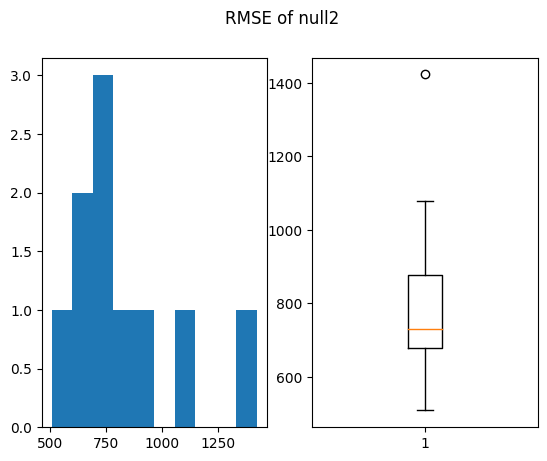

<Figure size 640x480 with 0 Axes>

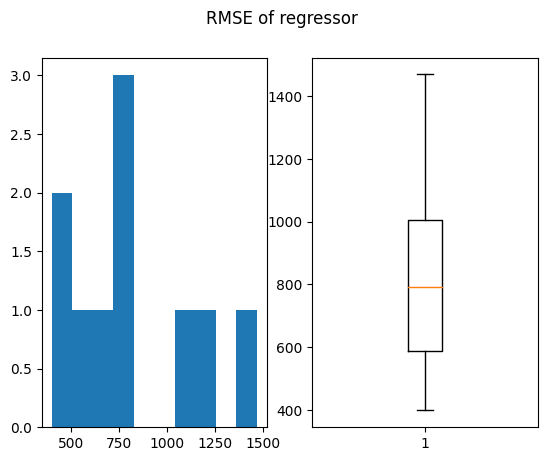

<Figure size 640x480 with 0 Axes>

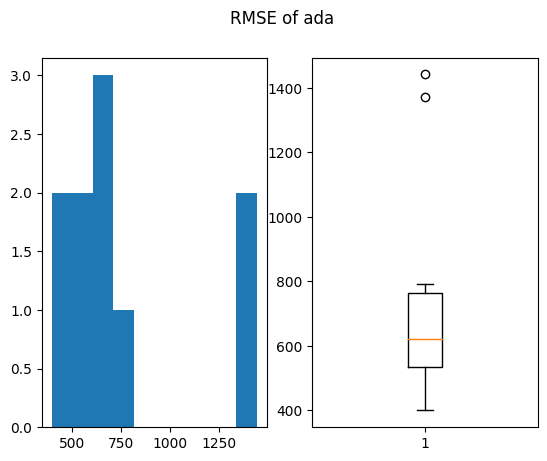

<Figure size 640x480 with 0 Axes>

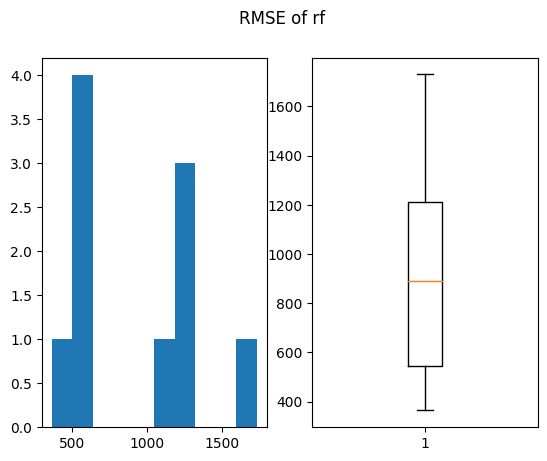

<Figure size 640x480 with 0 Axes>

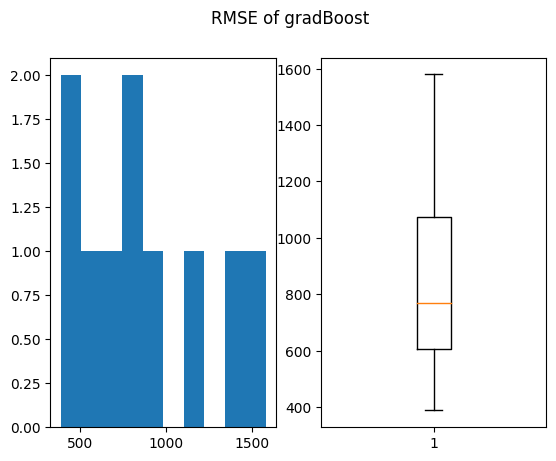

<Figure size 640x480 with 0 Axes>

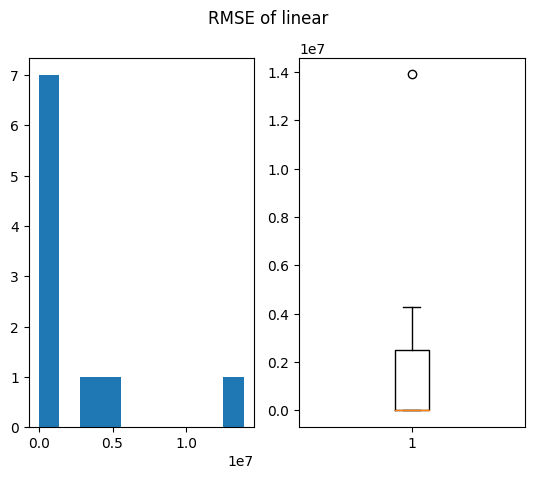

<Figure size 640x480 with 0 Axes>

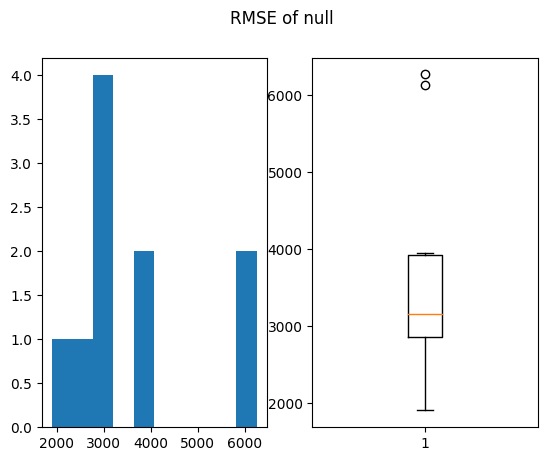

In [56]:
# Feature 2
KFoldPipeline(X, y, featureEngineerFunc2, models, 10, True)

C:\Users\DELL\AppData\Local\Temp\ipykernel_20912\1360628059.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test["pca"] = features_pca.transform(X_test)
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 

MSE of null2 : 533531.4335127556
RMSE of null2 : 730.1508993352018
MSE of regressor : 625891.5112003738
RMSE of regressor : 791.1194466774499
MSE of ada : 403149.4144189992
RMSE of ada : 634.5456091498129
MSE of rf : 840679.48479024
RMSE of rf : 880.8597380289616
MSE of gradBoost : 557808.728599385
RMSE of gradBoost : 745.8742525532751
MSE of linear : 1887279.9983352916
RMSE of linear : 1359.450882463203
MSE of null : 9968752.571479458
RMSE of null : 3157.2728578490787
Used attributes for regressor tree: 


<Figure size 640x480 with 0 Axes>

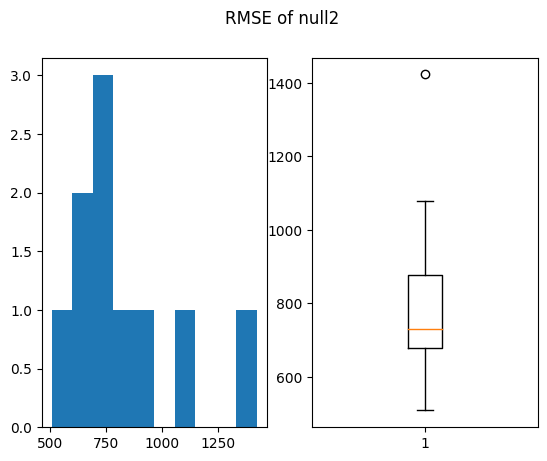

<Figure size 640x480 with 0 Axes>

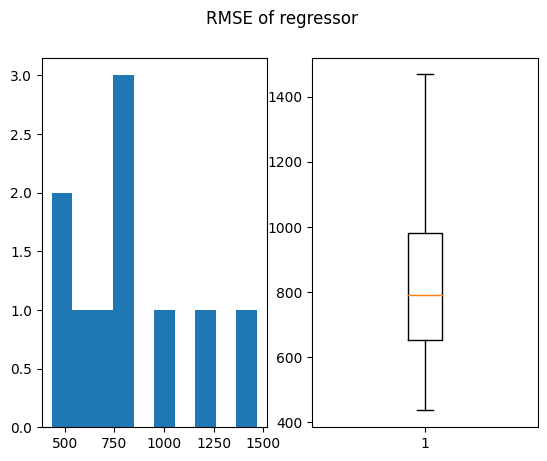

<Figure size 640x480 with 0 Axes>

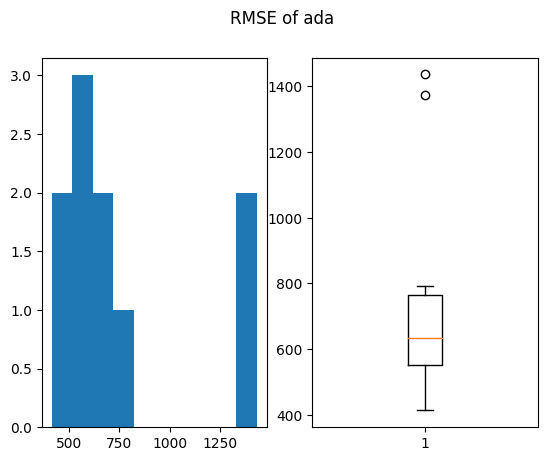

<Figure size 640x480 with 0 Axes>

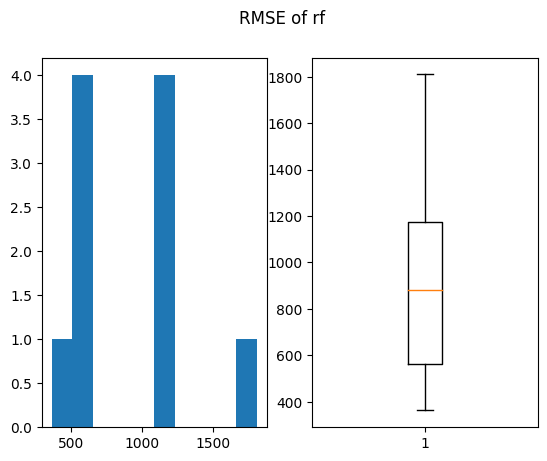

<Figure size 640x480 with 0 Axes>

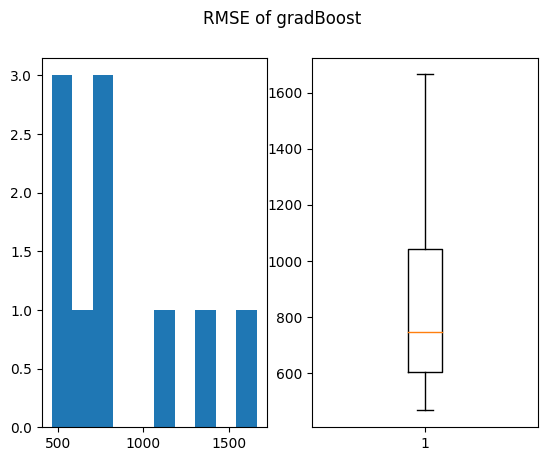

<Figure size 640x480 with 0 Axes>

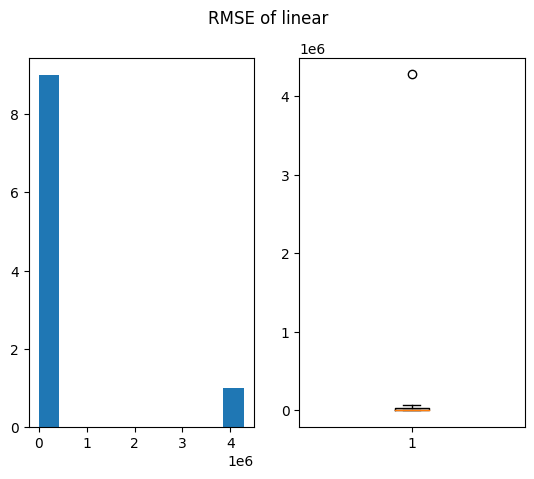

<Figure size 640x480 with 0 Axes>

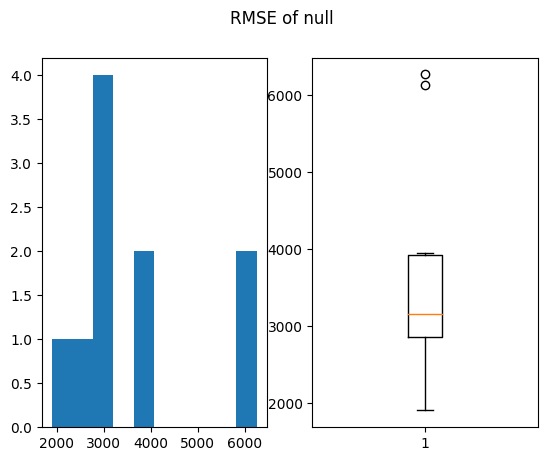

In [57]:
# Feature 4
KFoldPipeline(X, y, featureEngineerFunc4, models, 10, True)

In [58]:
# Final test, assume ada feature 4 is the best
# trainTestPipeline(X_train, X_test, y_train, y_test, featureEngineerFunc, models, printable = True)
models = {
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
}
trainTestPipeline(raw_X, X_test, raw_y, y_test, featureEngineerFunc4, models, True)

d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
d:\Python\.venv\Lib\site-packages\sklearn\preprocessing\_discretization.py:291: UserWarning: Bins whose widt

RMSE of  null2 : 840.6042623633698
RMSE of  ada : 207.88490400275342


(     Travel time to GPO (minutes)  2007 ERP age 10-14, persons   
 69                     155.599695                     0.072706  \
 84                     114.364692                     0.072701   
 93                      90.473714                     0.076182   
 95                      13.016887                     0.057107   
 62                     152.956477                     0.073388   
 ..                            ...                          ...   
 87                      11.629266                     0.045120   
 103                    295.724573                     0.069777   
 67                      38.178953                     0.080951   
 24                     240.694842                     0.071937   
 8                       19.419507                     0.068178   
 
      Child Protection and Family  Homelessness  Mental Health   
 69                      0.000052      0.000156       0.000520  \
 84                      0.000102      0.000145       0.000392

In [71]:
# Fit the model on everything for a published version, then derive relationship of attributes
models = {
    "ada": AdaBoostRegressor(
        DecisionTreeRegressor(max_depth=DEPTH), n_estimators=300, random_state=1301266),
}
preX = raw_raw_X
trainTestPipeline(raw_raw_X, raw_raw_X, raw_raw_y, raw_raw_y, featureEngineerFunc4, models, True)

transformed_X, _ = featureEngineerFunc4(preX, preX, raw_raw_y)

relevantAttributes = {}

model = models["ada"].best_estimator_
for i in range(len(model.estimators_)):
    estimator = model.estimators_[i].best_estimator_
    weight = model.estimator_weights_[i]
    tree_rules = export_text(estimator, feature_names=list(transformed_X.columns))
    for att in getSplitAttributes(tree_rules):
        if att not in relevantAttributes:
            relevantAttributes[att] = 0
        relevantAttributes[att] += weight

descPairs = list(relevantAttributes.items())
descPairs.sort(key = lambda x: -x[1])

plt.figure()
plt.title("Top 7 splitting attributes")
plt.barh([pair[0] for pair in descPairs[:7][::-1]], [pair[1] for pair in descPairs[:7][::-1]])
plt.show()

d:\Python\.venv\Lib\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- pca

  warnings.warn(message, FutureWarning)


ValueError: X has 165 features, but PCA is expecting 164 features as input.

In [28]:
# Try restricting to top 20 of highest correlation coeff for Linear model
from sklearn.metrics import normalized_mutual_info_score
from sklearn.preprocessing import KBinsDiscretizer

def getTopCorrCoeffCommunities(X_train, y_train):
    allScores = []
    for column in communities.columns:
        if column not in X_train.columns:
            continue
        score = abs(np.corrcoef(np.array(X_train[column]), np.array(y_train))[0][1])
        allScores.append((column, score))
    allScores.sort(key=lambda x: -x[1])
    return [col[0] for col in allScores][:20]

def featureEngineerLinearFunc2(X_train, X_test, y_train):
    # X_train, X_test = getPCA(X_train, X_test)

    top20Communities = getTopCorrCoeffCommunities(X_train, y_train)
    dropCol = []
    for column in communities.columns:
        if column in X.columns and column not in top20Communities:
            dropCol.append(column)

    X_train = X_train.drop(columns=dropCol)
    X_test = X_test.drop(columns=dropCol)
    return X_train, X_test

MSE of null2 : 428205.588030917
RMSE of null2 : 654.3662763885982
MSE of linear : 346583.90834130347
RMSE of linear : 588.598939001766
MSE of null : 6793443.447732713
RMSE of null : 2606.3806385903026
Used attributes for regressor tree: 
Series([], Name: count, dtype: int64)


<Figure size 640x480 with 0 Axes>

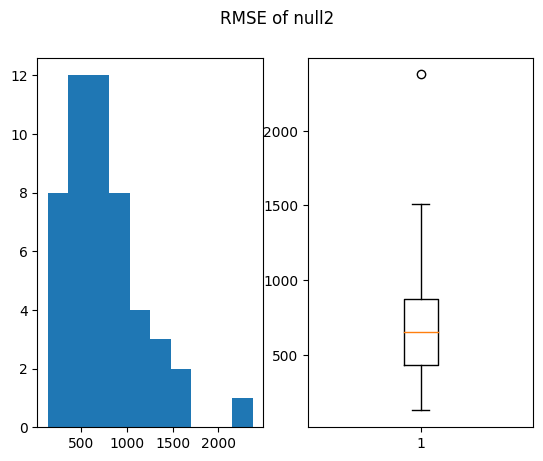

<Figure size 640x480 with 0 Axes>

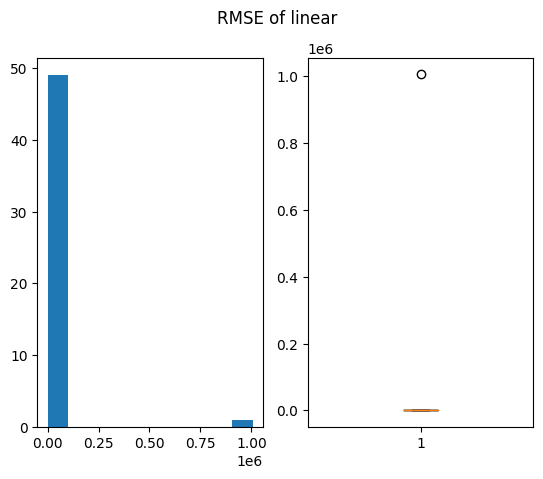

<Figure size 640x480 with 0 Axes>

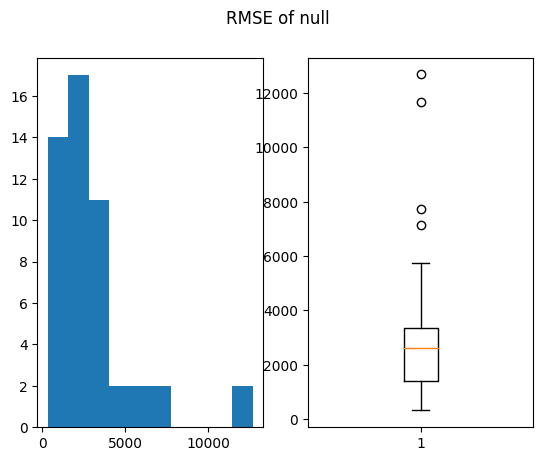

In [29]:
models = {
    "linear": LinearRegression(),
    "null": NullModel()
}

KFoldPipeline(X, y, featureEngineerLinearFunc2, models, 50, True, X_val=X_val, y_val=y_val)